In [1]:
import os, pickle, sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=2.2)
sns.set_context("talk")

pd.options.display.max_colwidth=200

from osc_discovery.acquisition_function import get_F, linear_correct_to_b3lyp
from osc_discovery import visualization_helpers

In [2]:
# Statistics about the chemical test space

df_chemical_space=pd.read_json('../data/df_chemical_space_chons_4rings.json', orient="split")
field='utility_function'

properties = ["XTB1_lamda_h", 'ehomo_gfn1_b3lyp']

for p in properties:
    df_chemical_space[p]=[linear_correct_to_b3lyp(p,row[p]) for i,row in df_chemical_space.iterrows()]

utility_functions = []
for i,row in df_chemical_space.iterrows():
    util = get_F([row[p] for p in properties])
    utility_functions.append(util)
df_chemical_space['utility_function']=utility_functions
    
df_chemical_space_unique = df_chemical_space.copy().drop_duplicates(subset='molecule_smiles')
    
print("Total in test space: {}".format(df_chemical_space_unique.shape[0]))
print("Favorable: {}".format(df_chemical_space_unique[df_chemical_space_unique['utility_function']>=-0.2].shape[0]))
print("Unfavorable: {}".format(df_chemical_space_unique[df_chemical_space_unique['utility_function']<-0.2].shape[0]))

Total in test space: 65552
Favorable: 2438
Unfavorable: 63114


In [3]:
# Get results directory for initial frame 
df_initial_population=pd.read_json('../data/df_initial_gfn1_testspace.json', orient="split")
y = [df_initial_population[prop].tolist() for prop in ["XTB1_lamda_h","ehomo_gfn1_b3lyp"]]
y = list(np.array(y).T)
df_initial_population["utility_function"] = 0.
df_initial_population["utility_function"] = [get_F(x) for x in y] 
res_dict_initial = visualization_helpers.get_results_dictionary(df_initial_population,
                                                                df_chemical_space, 
                                                                df_initial_population)

Population size 179
Population median: -0.5202380565452229
Population upper quartile: -0.3785015875557083
Chemical space median: -0.470324621087327
All samples above threshold: 2438
Found samples above threshold: 16
Rel score: 0.0893854748603352
Tot score: 0.006562756357670222


In [4]:
# helper functions for plotting

def get_funnel_score(df_chemical_space_unique, n_pop):
    lower_bound = df_chemical_space_unique[df_chemical_space_unique.utility_function>=-0.2].ehomo_gfn1_b3lyp.min()
    upper_bound = df_chemical_space_unique[df_chemical_space_unique.utility_function>=-0.2].ehomo_gfn1_b3lyp.max()
    df_sel1 = df_chemical_space_unique[(df_chemical_space_unique.ehomo_gfn1_b3lyp>=lower_bound) \
                                       & (df_chemical_space_unique.ehomo_gfn1_b3lyp<=upper_bound)]
    df_sel2 = df_sel1[df_sel1.utility_function>=-0.2]
    df_sel_all = df_chemical_space_unique[df_chemical_space_unique.utility_function>=-0.2]
    chance_find = df_sel2.shape[0] / df_sel1.shape[0]
    return  chance_find * n_pop / df_sel_all.shape[0]

print('get_funnel_score(df_chemical_space_unique, 5179)', get_funnel_score(df_chemical_space_unique, 5179))

    
def plot_res_dicts(df_sel, figsize=(4.7, 4), plot_funnel=True,
                   n_cols=1, labelfield='label', bbox_to_anchor=[], savename='',
                   linestyles=[], colors=[], labels=[], fontsize_legend=12):
    
    ''' Plot results of an AL run '''
    
    fig,ax = plt.subplots(figsize=figsize)

    ls='-'; lw=2.
    o=-1
    for i,row in df_sel.iterrows():
        o+=1
        if linestyles==[]:
            if o>10: ls='-.'; lw=2.
            if o>20: ls=':'; lw=2.5
            if o>30: ls='--'; lw=2.
        else:
            ls=linestyles[o]
            
        if labels==[]:
            label=row[labelfield]
        else:
            if labels[o]: label=row[labelfield]
            else: label=''
            
        if colors==[]:    
            plt.plot( [ x['population_size'] for x in row.res_dicts ], 
            [ x['tot_score'] for x in row.res_dicts ], label=label, ls=ls, lw=lw)
        else:
            plt.plot( [ x['population_size'] for x in row.res_dicts ], 
                      [ x['tot_score'] for x in row.res_dicts ], 
                      label=label, ls=ls, lw=lw, c=colors[o] )


    plt.ylabel('$S\mathrm{(}N\mathrm{)}$')
    plt.xlabel('$N$')
    
    
    still_to_plot=True
    # Funnel strategy
    if plot_funnel:
        for i,row in df_sel.iterrows():
            if still_to_plot and row.res_dicts[-1]['population_size']==max([row2.res_dicts[-1]['population_size'] for j,row2 in df_sel.iterrows()]):
                plt.plot([ x['population_size'] for x in row.res_dicts ],
                  [ get_funnel_score(df_chemical_space_unique, x['population_size']) for x in row.res_dicts ],
                        c='black', ls='-.', label='Computational funnel')
                still_to_plot=False


    box = ax.get_position()
    ax.set_position([box.x0, box.y0, #+ box.height * 0.1,
                 box.width, box.height * 0.9])
    
    #if bbox_to_anchor==[]:
    #    bbox_to_anchor=(0.5, + 1.6/n_cols+o*0.01/n_cols)
    
    #
    ax.legend(loc='upper center',bbox_to_anchor=bbox_to_anchor, handlelength=1.7, handletextpad=1,
          fancybox=False, shadow=False, ncol=n_cols, framealpha=0.7, fontsize=fontsize_legend)

    fig.axes[-1].set_facecolor('ghostwhite')
    plt.grid(True)
    plt.xticks([0,1000,2000,3000,4000,5000])
    plt.yticks([0.1,0.3,0.5,0.6,0.7,0.8,0.9])
        
        
    plt.tight_layout()
    if savename!='': plt.savefig(savename)
        

def get_summary_frames():
    """ Read results of runs from directory """
        
    # Reading results of runs
    kappas=[]
    n_batches=[]
    two_folds=[]
    population_sizes=[]
    total_scores=[]
    folders=[]
    res_dicts_list=[]
    labels_list=[]
    finished_list=[]
    labels2_list=[]
    suffix=[]
    reduced_search_space=[]
    depth_search=[]
    Ndeep=[]
    df_populations=[]

    list_dir_res=[x for x in os.listdir('.') if '_learner_results_script' in x if os.path.isfile(os.path.join(x, 'res_dicts.pkl'))]
    plt.figure(figsize=(10,10))

    for l in list_dir_res:

        if not 'res_dicts.pkl' in os.listdir(l): 
            print('not found', l)
            continue

        with open('{}/res_dicts.pkl'.format(l), 'rb') as out:
            res_dicts = pickle.load(out)
            res_dicts=[x for x in res_dicts if x['population_size']<=5179]
            folders.append(l)

            res_dicts_list.append( [res_dict_initial]+res_dicts )
            kappas.append( float(l.split('kappa')[1].split('_')[1].split('_')[0]) )
            n_batches.append( int(l.split('nbatch')[1].split('_')[1].split('_')[0]) )
            two_folds.append( str(l.split('twofold')[1].split('_')[1].split('_')[0]) )
            total_scores.append(res_dicts[-1]['tot_score'])
            population_sizes.append(res_dicts[-1]['population_size'])
            df_populations.append(pd.read_json("{}/df_population.json".format(l), orient="split"))

            if 'rwssearch_True' in l or 'rwssearch_1' in l:
                rws_search_str = l.split('rwssearch_')[1].split('_')[0]
                reduced_search_space.append( rws_search_str.split('-')[0] )
                depth_search.append( int(rws_search_str.split('-')[1]) )
                Ndeep.append( int(rws_search_str.split('-')[2]) )
            else:
                reduced_search_space.append( '0' )
                depth_search.append( 0 )
                Ndeep.append( 0 )

            if 'suffix' in l: suffix.append( l.split('suffix_')[-1] )
            else: suffix.append( '' )

            if res_dicts[-1]['population_size']==5179: 
                finished_list.append(True); print('FINISHED')
            else: finished_list.append(False)


            label='$\kappa=%2.1f$,  ' % (kappas[-1])
            label+='$N_{\mathrm{batch}}=%d$' % (n_batches[-1])
            label+='  $%sG$' % ((two_folds[-1]=='True' or two_folds[-1]=='1')+1)
            label+='  $RWS=%s$  $C=%s,D=%s$' % (str(reduced_search_space[-1]=='True')[0], 
                                                str(Ndeep[-1]), str(depth_search[-1]) )
            if finished_list[-1]: label+=' F={}'.format(str(finished_list[-1]))
            label+='  $Pop=%s$' % (str(res_dicts[-1]['population_size']))
            labels_list.append(label)

            labels2=label.split()
            labels2_list.append(' '.join(labels2[0:2]) )

            print(label)
            print(l)
            print(res_dicts[-1])
            print(df_populations[-1].added_in_round.max(), df_populations[-1].shape)
            print('')


    df_res=pd.DataFrame(data={'kappa': kappas,
                              'n_batches': n_batches,
                              'two_folds': two_folds,
                              'population_sizes': population_sizes,
                              'total_scores': total_scores,
                              'folder': folders,
                              'res_dicts': res_dicts_list,
                              'label': labels_list,
                              'label2': labels2_list,
                              'reduced_search_space': reduced_search_space,
                              'depth_search': depth_search,
                              'Ndeep': Ndeep,
                              'finished': finished_list, 
                              'suffix': suffix,
                              'df_population': df_populations})
    return df_res

get_funnel_score(df_chemical_space_unique, 5179) 0.38072484010879953


FINISHED
$\kappa=0.0$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_0.0_nbatch_100_runs_50_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.22001674188697865, 'population_upper_quartile': -0.18552075455821143, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1778, 'rel_score': 0.34330951921220315, 'tot_score': 0.7292863002461034, 'uncomputed_size': 12890}
52 (5179, 13)

FINISHED
$\kappa=0.0$,  $N_{\mathrm{batch}}=200$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_0.0_nbatch_200_runs_25_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.21842473677904473, 'population_upper_quartile': -0.18552075455821143, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1801, 'rel_score

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=50$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_50_runs_100_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.21723379725285508, 'population_upper_quartile': -0.18523909267577143, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1833, 'rel_score': 0.35392932998648385, 'tot_score': 0.7518457752255947, 'uncomputed_size': 13564}
102 (5179, 13)

FINISHED
$\kappa=3.0$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_3.0_nbatch_100_runs_50_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.2170029693544912, 'population_upper_quartile': -0.18364743619767326, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1879, 'rel_score'

<Figure size 720x720 with 0 Axes>

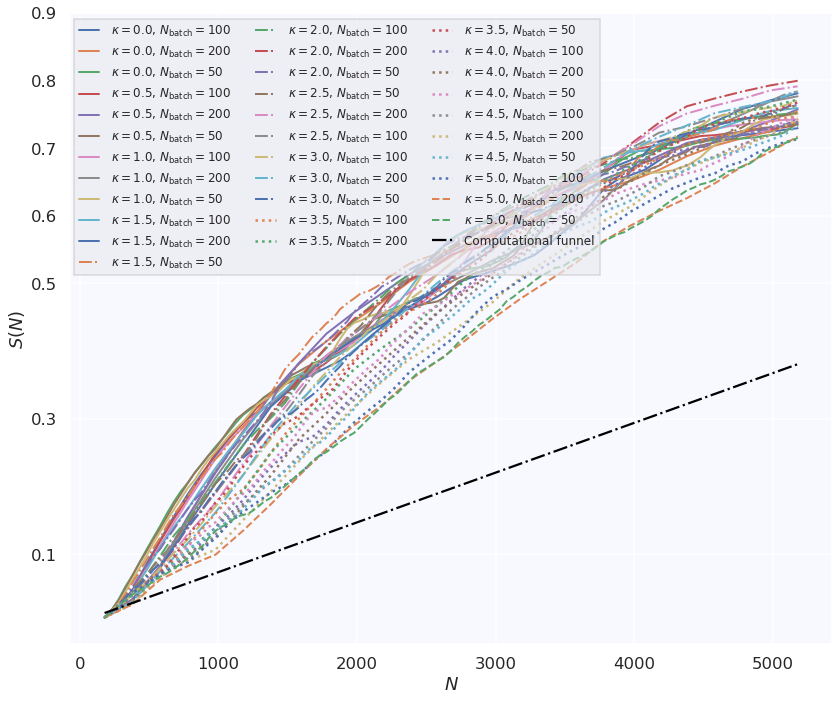

Missing:
0.7994257588187038 0.7132895816242822


In [5]:
import os
os.chdir("../data/runs_1G/")
df_res=get_summary_frames()
os.chdir("../../figures/")

# filter
df_sel=df_res 
df_sel=df_sel.sort_values(by='kappa')

plot_res_dicts(df_sel, figsize=(12,10), n_cols=3, savename="SI_figures/all_runs_1G.pdf",
                labelfield='label2', bbox_to_anchor=[0.35,1.0])
plt.show()


print("Missing:")
kappas=[0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
n_batches=[50,100,200]
for k in kappas:
    for n in n_batches:
        df_sel=df_res[(df_res.kappa==k)&(df_res.n_batches==n)]
        if df_sel.shape[0]==0: print("miss",k,n)
        if df_sel.population_sizes.values[0]<5179:
            print(df_sel.shape, k, n)


df_sel=df_res[df_res.finished==True]
print(df_sel.total_scores.max(), df_sel.total_scores.min())

In [6]:
import os
os.chdir("../data/runs_2G/")
df_res=get_summary_frames()
os.chdir("../../figures/")

# filter
df_sel=df_res 
df_sel=df_sel.sort_values(by=['kappa',"n_batches"])
#df_sel=df_sel[df_sel.kappa==2.5]

plot_res_dicts(df_sel, figsize=(12,10), n_cols=3, savename="SI_figures/all_runs_2G.pdf",
                labelfield='label2', bbox_to_anchor=[0.35,1.0])
plt.show()

print("Missing:")
kappas=[0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
n_batches=[50,100,200]
for k in kappas:
    for n in n_batches:
        df_sel=df_res[(df_res.kappa==k)&(df_res.n_batches==n)]
        if df_sel.population_sizes.values[0]<5179:
            print(df_sel.shape, k, n)

df_sel=df_res[df_res.finished==True]
print(df_sel.total_scores.max(), df_sel.total_scores.min())

FINISHED
$\kappa=0.0$,  $N_{\mathrm{batch}}=100$  $2G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_1_kappa_0.0_nbatch_100_runs_50_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.2116052420741355, 'population_upper_quartile': -0.18256037462690106, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1999, 'rel_score': 0.3859818497779494, 'tot_score': 0.8199343724364233, 'uncomputed_size': 28237}
52 (5179, 13)

FINISHED
$\kappa=0.0$,  $N_{\mathrm{batch}}=200$  $2G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_1_kappa_0.0_nbatch_200_runs_25_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.21605673128109928, 'population_upper_quartile': -0.18621701956360326, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1827, 'rel_score':

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=50$  $2G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_1_kappa_2.5_nbatch_50_runs_100_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.2118469370278385, 'population_upper_quartile': -0.18179522978207668, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 2021, 'rel_score': 0.3902297740876617, 'tot_score': 0.8289581624282198, 'uncomputed_size': 27718}
102 (5179, 13)

FINISHED
$\kappa=3.0$,  $N_{\mathrm{batch}}=100$  $2G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_1_kappa_3.0_nbatch_100_runs_50_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.21276263395842224, 'population_upper_quartile': -0.1811557682703171, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 2028, 'rel_score': 

FINISHED
$\kappa=5.0$,  $N_{\mathrm{batch}}=50$  $2G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_1_kappa_5.0_nbatch_50_runs_100_production_False_rwssearch_0_suffix_
{'population_size': 5179, 'population_median': -0.23066094501622192, 'population_upper_quartile': -0.1866417999226306, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1685, 'rel_score': 0.3253523846302375, 'tot_score': 0.6911402789171452, 'uncomputed_size': 30015}
102 (5179, 13)



<Figure size 720x720 with 0 Axes>

Missing:
0.8470057424118129 0.6853978671041837


In [8]:
# Table S1

os.chdir("../data/runs_decreased_search_space")
df_res=get_summary_frames()
os.chdir("../../figures/")

settings_depth=[1,2,3,4,5,10]
settings_max_candidates=[100,250,500,1000]

for d in settings_depth:
    for mc in settings_max_candidates:
        df_sel=df_res[(df_res.n_batches==100) & (df_res.Ndeep==mc) &\
                      (df_res.depth_search==d) & (df_res['finished']>=-1)&\
                      (df_res.kappa==2.5) & (df_res.reduced_search_space=="1")]
        rangex= (df_sel.total_scores.max()-df_sel.total_scores.median(),
                 df_sel.total_scores.min()-df_sel.total_scores.median())
        print(mc, d, df_sel.shape, df_sel.total_scores.median(), rangex, 
              len(df_sel.folder.tolist()), df_sel.population_sizes.tolist(), 
              np.around(df_sel.total_scores.tolist(),3))#,df_sel.folder.tolist()) #
        if not df_sel.shape[0] == 5 or not np.all(df_sel.population_sizes.values==5179):
            print("Not finished")


FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=1000,D=1$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-1-1000_suffix_r12
{'population_size': 5179, 'population_median': -0.21834132732262085, 'population_upper_quartile': -0.1855553140996325, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1813, 'rel_score': 0.35006758061401816, 'tot_score': 0.743642329778507, 'uncomputed_size': 12788}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=1000,D=1$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-1-1000_suffix_r2
{'population_size': 5179, 'population_median': -0.21996996287383105, 'population_upper_quartile': -0.18527785816825532, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_thres

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=500,D=1$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-1-500_suffix_r2
{'population_size': 5179, 'population_median': -0.2231631609053174, 'population_upper_quartile': -0.18715753248640324, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1704, 'rel_score': 0.32902104653407993, 'tot_score': 0.6989335520918786, 'uncomputed_size': 12349}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=500,D=1$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-1-500_suffix_r22
{'population_size': 5179, 'population_median': -0.22849451724333178, 'population_upper_quartile': -0.18876974727659818, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshol

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=250,D=10$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-10-250_suffix_r22
{'population_size': 5179, 'population_median': -0.21328552896624384, 'population_upper_quartile': -0.18296958247385348, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1971, 'rel_score': 0.3805754006564974, 'tot_score': 0.8084495488105005, 'uncomputed_size': 13879}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=250,D=10$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-10-250_suffix_r32
{'population_size': 5179, 'population_median': -0.2143927724390293, 'population_upper_quartile': -0.18364743619767326, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_thre

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=250,D=2$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-2-250_suffix_r12
{'population_size': 5179, 'population_median': -0.22075720801520127, 'population_upper_quartile': -0.18705134171490356, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1742, 'rel_score': 0.3363583703417648, 'tot_score': 0.7145200984413453, 'uncomputed_size': 12676}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=250,D=2$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-2-250_suffix_r2
{'population_size': 5179, 'population_median': -0.21986844157793442, 'population_upper_quartile': -0.1862659044915692, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=100,D=3$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-3-100_suffix_r12
{'population_size': 5179, 'population_median': -0.2212965975802254, 'population_upper_quartile': -0.18671402697555464, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1743, 'rel_score': 0.3365514578103881, 'tot_score': 0.7149302707136997, 'uncomputed_size': 13102}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=100,D=3$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-3-100_suffix_r2
{'population_size': 5179, 'population_median': -0.2220697110034175, 'population_upper_quartile': -0.18745109597733134, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold'

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=1000,D=4$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-4-1000_suffix_r22
{'population_size': 5179, 'population_median': -0.21320501950560225, 'population_upper_quartile': -0.18251253885442859, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1984, 'rel_score': 0.3830855377486001, 'tot_score': 0.8137817883511075, 'uncomputed_size': 14026}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=1000,D=4$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-4-1000_suffix_r32
{'population_size': 5179, 'population_median': -0.2110259730936691, 'population_upper_quartile': -0.18104108687574524, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_thre

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=500,D=4$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-4-500_suffix_r22
{'population_size': 5179, 'population_median': -0.21352688260826944, 'population_upper_quartile': -0.1826974104069451, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1973, 'rel_score': 0.38096157559374394, 'tot_score': 0.8092698933552092, 'uncomputed_size': 13849}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=500,D=4$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-4-500_suffix_r32
{'population_size': 5179, 'population_median': -0.21226230937389645, 'population_upper_quartile': -0.18143862215406192, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_thresho

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=250,D=5$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-5-250_suffix_r42
{'population_size': 5179, 'population_median': -0.21626164364574177, 'population_upper_quartile': -0.18527467578997864, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1854, 'rel_score': 0.3579841668275729, 'tot_score': 0.760459392945037, 'uncomputed_size': 13690}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=500,D=5$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_1-5-500_suffix_r12
{'population_size': 5179, 'population_median': -0.2131654488053109, 'population_upper_quartile': -0.18246797280774718, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold

<Figure size 720x720 with 0 Axes>


../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.5/df_population.json
Control 1.2996366686307548e-07
S(5179) 0.7768662838392125
-0.36782252618102185 -0.13414668903977017

../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.6/df_population.json
Control 1.3028913423834831e-07
S(5179) 0.783839212469237
-0.3694476685269244 -0.1342986480657472

../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.7/df_population.json
Control 1.3083004191810632e-07
S(5179) 0.783839212469237
-0.3737865148346038 -0.13414668903977017

../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.8/df_population.json
Control 1.291899036151567e-07
S(5179) 0.7575881870385562
-0.39148082971914827 -0.1345

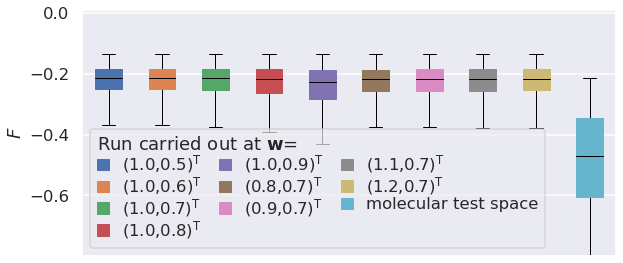

../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.5/df_population.json
107.26372632765 281.11207199686976
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.6/df_population.json
106.80666487534 276.41907910952955
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.7/df_population.json
105.85831674824 272.66299038936995
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.8/df_population.json
106.02474788434 264.10941102661
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.9/df_population.json
105.15003469365 264.71410132580985
../data/runs_weights/active_learner_results_script_twofold

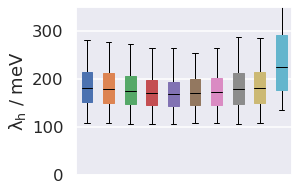

../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.5/df_population.json
-5.4276344000000005 -4.8616136
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.6/df_population.json
-5.4558692 -4.8592216
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.7/df_population.json
-5.479872 -4.842735200000001
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.8/df_population.json
-5.5333056 -4.8165152
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w1.0-0.9/df_population.json
-5.601082 -4.813755200000001
../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_product

In [9]:
# Figure S7: weights

all_weights=[]

weights=[1.0,0.5]
all_weights.append(weights)

weights=[1.0,0.6]
all_weights.append(weights)

weights=[1.0,0.7]
all_weights.append(weights)

weights=[1.0,0.8]
all_weights.append(weights)

weights=[1.0,0.9] #nf
all_weights.append(weights)

weights=[0.8,0.7]
all_weights.append(weights)

weights=[0.9,0.7]
all_weights.append(weights)

weights=[1.1,0.7]
all_weights.append(weights)

weights=[1.2,0.7]
all_weights.append(weights)


plt.figure(figsize=(9,4))
utilities=[]
bps=[]
labels=[]

for i,weights in enumerate(all_weights): 
    fname="../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w{0}-{1}/df_population.json".format(weights[0], weights[1])
    print("")
    print(fname)
    if not os.path.isfile(fname): continue
    df_pop=pd.read_json(fname, orient="split")   
    utility_functions = []
    utility_functions_control =[]
    
    for j,row in df_pop.iterrows():
        util = get_F([row[p] for p in properties], weights=[1.0,0.7])
        utility_functions.append(util)
        
        util = get_F([row[p] for p in properties], weights=weights)
        utility_functions_control.append(util)
    
    df_pop['utility2']=utility_functions
    df_pop['utility_function_control']=utility_functions_control

    print('Control {}'.format(np.sum(np.abs(df_pop['utility_function_control']-df_pop['utility_function']))))
    
    print("S({})".format(df_pop.shape[0]),df_pop[df_pop.utility2>-0.2].shape[0]/2438)
    
    print(df_pop.utility2.quantile(q=0.05), df_pop.utility2.quantile(q=0.95))

    
    utilities.append(utility_functions)
    labels.append("({},{}".format(weights[0],weights[1])+")$^\mathrm{T}$")
    
    bp=plt.boxplot([utility_functions],positions=[i], patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5,95],
                boxprops=dict(facecolor="C"+str(int(i)), color="C"+str(int(i))))
    bps.append(bp)
    
bp=plt.boxplot([df_chemical_space_unique.utility_function.tolist()],positions=[i+1], 
               patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5,95],
                boxprops=dict(facecolor="C"+str(int(i+1)), color="C"+str(int(i+1))))
bps.append(bp)
labels.append("molecular test space")

plt.ylabel("$F$")
#plt.xlabel("Discovery runs")
plt.xticks([])
leg=plt.legend([bp["boxes"][0] for bp in bps], labels, ncol=3, framealpha=0.7,
            title="Run carried out at $\mathrm{\mathbf {w}}$=",
            labelspacing=0.0, loc="lower left", handlelength=0.75, columnspacing=1)
leg._legend_box.align = "left"
plt.ylim(-0.799,0.01)
plt.tight_layout()
plt.savefig("SI_figures/F_weights.pdf")
plt.show()




plt.figure(figsize=(4.5,3))
for i,weights in enumerate(all_weights): 
    fname="../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w{0}-{1}/df_population.json".format(weights[0], weights[1])
    print(fname)
    if not os.path.isfile(fname): continue

    df_pop=pd.read_json(fname, orient="split")   
    
    print(df_pop.XTB1_lamda_h.quantile(q=0.05), df_pop.XTB1_lamda_h.quantile(q=0.95))
        
    bp=plt.boxplot([df_pop.XTB1_lamda_h.tolist()],positions=[i], patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5, 95],
                boxprops=dict(facecolor="C"+str(int(i)), color="C"+str(int(i))))
    bps.append(bp)
bp=plt.boxplot([df_chemical_space_unique.XTB1_lamda_h.tolist()],positions=[i+1], 
               patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5, 95],
                boxprops=dict(facecolor="C"+str(int(i+1)), color="C"+str(int(i+1))))
bps.append(bp)
plt.ylabel("$\mathrm{\lambda_h}$ / meV")
plt.xticks([])
plt.ylim(0,350)
plt.tight_layout()
plt.savefig("SI_figures/lambda_weights.pdf")
plt.show()




plt.figure(figsize=(4.5,3))
for i,weights in enumerate(all_weights): 
    fname="../data/runs_weights/active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_w{0}-{1}/df_population.json".format(weights[0], weights[1])
    print(fname)
    if not os.path.isfile(fname): continue

    df_pop=pd.read_json(fname, orient="split")   
    
    print(df_pop.ehomo_gfn1_b3lyp.quantile(q=0.05), df_pop.ehomo_gfn1_b3lyp.quantile(q=0.95))
        
    bp=plt.boxplot([df_pop.ehomo_gfn1_b3lyp.tolist()],positions=[i], patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5, 95],
                boxprops=dict(facecolor="C"+str(int(i)), color="C"+str(int(i))))
    bps.append(bp)
    
bp=plt.boxplot([df_chemical_space_unique.ehomo_gfn1_b3lyp.tolist()],positions=[i+1], 
               patch_artist=True, showfliers=False,
                medianprops=dict(color="black"),widths = 0.5, whis=[5, 95],
                boxprops=dict(facecolor="C"+str(int(i+1)), color="C"+str(int(i+1))))
bps.append(bp)
plt.hlines(-5.1,-0.5,9.5, ls="--", color="gray")
plt.ylabel("$\mathrm{ϵ_{HOMO}}$ / eV")
plt.xticks([])
plt.ylim(-4.25,-6.25)
plt.tight_layout()
plt.savefig("SI_figures/ehomo_weights.pdf")
plt.show()

In [10]:
# Figure S8: fingerprint radii

os.chdir("../data/runs_fingerprint_radius/")
df_res=get_summary_frames()
os.chdir("../../figures/")

df_res["label3"]=""

folder="active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp1"
df_sel=df_res[df_res.folder==folder]
df_res.at[df_sel.index.values[0], "label3"]="Bond radius 1"

folder="active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp2"
df_sel=df_res[df_res.folder==folder]
df_res.at[df_sel.index.values[0], "label3"]="Bond radius 2"

folder="active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp3"
df_sel=df_res[df_res.folder==folder]
df_res.at[df_sel.index.values[0], "label3"]="Bond radius 3"

folder="active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp4"
df_sel=df_res[df_res.folder==folder]
df_res.at[df_sel.index.values[0], "label3"]="Bond radius 4"

folder="active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp5"
df_sel=df_res[df_res.folder==folder]
df_res.at[df_sel.index.values[0], "label3"]="Bond radius 5"

df_res=df_res.sort_values(by="label3")

plot_res_dicts(df_res, figsize=(6,5), n_cols=1, bbox_to_anchor=[0.6,.45], fontsize_legend=15,
               labelfield="label3", plot_funnel=False, savename="SI_figures/bond_radii_sensitivty.pdf")

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp1
{'population_size': 5179, 'population_median': -0.21743043287068825, 'population_upper_quartile': -0.1853982286898971, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1827, 'rel_score': 0.3527708051747442, 'tot_score': 0.7493847415914684, 'uncomputed_size': 13796}
52 (5179, 13)

FINISHED
$\kappa=2.5$,  $N_{\mathrm{batch}}=100$  $1G$  $RWS=F$  $C=0,D=0$ F=True  $Pop=5179$
active_learner_results_script_twofold_0_kappa_2.5_nbatch_100_runs_50_production_False_rwssearch_0_suffix_fp2
{'population_size': 5179, 'population_median': -0.21542454059924412, 'population_upper_quartile': -0.18337034785376866, 'chemical_space_median': -0.470324621087327, 'all_samples_above_threshold': 2438, 'found_samples_above_threshold': 1911, 'rel_s

<Figure size 720x720 with 0 Axes>